In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/Bark images 2"
SWEEP_DIR = "/content/drive/MyDrive/bark_sweeps/resnet50_InputSweep_kfold"


Mounted at /content/drive


## SETUP

In [2]:
import random
from pathlib import Path
import os, random
import numpy as np
import torch

SEED = 42

def seed_everything(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Deterministic (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
print("Seed set to:", SEED)

def list_samples_grouped_by_tree(root_dir, exts={".jpg",".jpeg",".png",".bmp",".webp"}):
    root = Path(root_dir)
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}

    samples = []  # (img_path, label_idx, group_id)
    for cls in classes:
        cls_dir = root / cls
        tree_ids = sorted([p.name for p in cls_dir.iterdir() if p.is_dir()])
        for tree_id in tree_ids:
            tree_dir = cls_dir / tree_id
            group_id = f"{cls}/{tree_id}"  # unique per tree within class
            for img_path in tree_dir.rglob("*"):
                if img_path.is_file() and img_path.suffix.lower() in exts:
                    samples.append((str(img_path), class_to_idx[cls], group_id))
    return samples, classes, class_to_idx

def make_kfold_splits_by_tree(samples, n_splits=5, seed=42):
    """
    Returns: folds = list of (train_samples, test_samples) length n_splits
    Each element in train_samples/test_samples is (path, y, group_id)
    """
    rng = random.Random(seed)

    # group samples by class -> group_id -> items
    by_class = {}
    for path, y, group in samples:
        by_class.setdefault(y, {}).setdefault(group, []).append((path, y, group))

    folds = []
    for _ in range(n_splits):
        folds.append(([], []))  # (train, test)

    # For each class, split its tree-groups across folds
    for y, groups_dict in by_class.items():
        groups = list(groups_dict.keys())
        rng.shuffle(groups)

        # round-robin assign groups to folds (balanced even if not divisible by n_splits)
        groups_in_fold = [[] for _ in range(n_splits)]
        for i, g in enumerate(groups):
            groups_in_fold[i % n_splits].append(g)

        # build each fold’s train/test samples
        for k in range(n_splits):
            test_groups = set(groups_in_fold[k])

            train_k, test_k = folds[k]
            for g, items in groups_dict.items():
                (test_k if g in test_groups else train_k).extend(items)

    # shuffle samples inside each fold for convenience
    for k in range(n_splits):
        train_k, test_k = folds[k]
        rng.shuffle(train_k)
        rng.shuffle(test_k)

    return folds


samples, class_names, class_to_idx = list_samples_grouped_by_tree(DATA_DIR)

fold_count = 3

folds = make_kfold_splits_by_tree(samples, n_splits=fold_count, seed=SEED)

# Leak check per fold + print sizes
for k, (train_samples, test_samples) in enumerate(folds):
    train_groups = {g for _,_,g in train_samples}
    test_groups  = {g for _,_,g in test_samples}
    assert train_groups.isdisjoint(test_groups), f"Leakage in fold {k}!"

    print(f"Fold {k}: train={len(train_samples)} test={len(test_samples)}")

print("Classes:", class_names)

Seed set to: 42
Fold 0: train=708 test=418
Fold 1: train=717 test=409
Fold 2: train=827 test=299
Classes: ['acacia', 'apple', 'candle', 'cherry', 'cypress', 'fig', 'katsura', 'linden', 'magnolia', 'oak', 'olive', 'palm', 'pine', 'plane', 'red-gum', 'sakura']


### MODEL AND CHECKPOINTS


In [3]:
from PIL import Image
from torch.utils.data import Dataset

class BarkDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, y, _group = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y


In [4]:
import torch

def save_checkpoint(path, *, epoch, model, optimizer, scheduler=None, scaler=None,
                    best_metric=None, class_names=None, extra=None):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_metric": best_metric,
        "class_names": class_names,
        "extra": extra or {},
        "torch_version": torch.__version__,
    }
    if scheduler is not None:
        ckpt["scheduler_state"] = scheduler.state_dict()
    if scaler is not None:
        ckpt["scaler_state"] = scaler.state_dict()
    torch.save(ckpt, path)


In [5]:
import os, json, time
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def make_loaders(train_samples, test_samples, input_size, batch_size=32):
    train_tfms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
        transforms.ToTensor(),
    ])
    test_tfms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])

    train_ds = BarkDataset(train_samples, transform=train_tfms)
    test_ds  = BarkDataset(test_samples,  transform=test_tfms)

    if input_size >= 384:
        batch_size = min(batch_size, 16)
    if input_size >= 450:
        batch_size = min(batch_size, 8)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

def make_optimizer(name, params, lr, weight_decay, momentum=0.9):
    name = name.lower()
    if name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    if name == "rmsprop":
        return torch.optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {name}")

def train_one(train_samples, test_samples, config, run_dir):
    run_dir = Path(run_dir)
    run_dir.mkdir(parents=True, exist_ok=True)

    with open(run_dir/"config.json", "w") as f:
        json.dump(config, f, indent=2)

    # Model
    if config["pretrained"]:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    else:
        model = models.resnet50(weights=None)

    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    # Loss
    criterion = nn.CrossEntropyLoss(label_smoothing=config["label_smoothing"])

    # Optimizer (swept)
    optimizer = make_optimizer(
        config["optimizer"],
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"],
        momentum=config.get("momentum", 0.9),
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))

    train_loader, test_loader = make_loaders(train_samples, test_samples, config["input_size"], batch_size=config.get("batch_size", 32))

    best_acc, best_epoch = 0.0, -1
    history = []

    def run_epoch(loader, train: bool):
        model.train(train)
        total_loss, correct, total = 0.0, 0, 0

        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            with torch.set_grad_enabled(train):
                with torch.amp.autocast('cuda', enabled=(device == "cuda")):
                    logits = model(x)
                    loss = criterion(logits, y)

                if train:
                    optimizer.zero_grad(set_to_none=True)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

            total_loss += float(loss.item()) * x.size(0)
            correct += int((logits.argmax(1) == y).sum().item())
            total += int(x.size(0))

        return total_loss / max(total, 1), correct / max(total, 1)

    last_path = run_dir / "last.pt"
    best_path = run_dir / "best.pt"

    for epoch in range(config["epochs"]):
        tr_loss, tr_acc = run_epoch(train_loader, True)
        va_loss, va_acc = run_epoch(test_loader, False)
        scheduler.step()

        row = {
            "epoch": epoch,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_loss": va_loss, "val_acc": va_acc,
        }
        history.append(row)

        save_checkpoint(
            str(last_path),
            epoch=epoch, model=model, optimizer=optimizer,
            scheduler=scheduler, scaler=scaler,
            best_metric=best_acc, class_names=class_names,
            extra=row
        )

        if va_acc > best_acc:
            best_acc, best_epoch = va_acc, epoch
            save_checkpoint(
                str(best_path),
                epoch=epoch, model=model, optimizer=optimizer,
                scheduler=scheduler, scaler=scaler,
                best_metric=best_acc, class_names=class_names,
                extra=row
            )

    with open(run_dir/"history.json", "w") as f:
        json.dump(history, f, indent=2)

    return {
        "best_val_acc": best_acc,
        "best_epoch": best_epoch,
        "final_val_acc": history[-1]["val_acc"]
    }


Device: cuda


In [ ]:
import itertools, random
from pathlib import Path

sweep_dir = Path(SWEEP_DIR)
sweep_dir.mkdir(parents=True, exist_ok=True)

grid = {
    "pretrained": [True],
    "optimizer": [ "adamw"],
    "input_size": [150, 250, 350, 450],
    "epochs": [30],
    "label_smoothing": [ 0.1],
    "weight_decay": [0.05],
    "lr": [ 3e-4],
    "momentum": [0.9],
}

configs = [dict(zip(grid.keys(), vals)) for vals in itertools.product(*grid.values())]

# Prune combinations that are almost always bad
pruned = []
for c in configs:
    if c["pretrained"]:
        # Fine-tuning: mainly AdamW ; SGD can work
        if c["optimizer"] in ["adam", "adamw"] and c["lr"] > 3e-3:
            continue
        if c["optimizer"] == "sgd" and c["lr"] < 1e-3:
            continue
    else:
        # random initialization: mainly SGD prefers higher LR; AdamW can work
        if c["optimizer"] == "sgd" and c["lr"] < 1e-2:
            continue
        if c["optimizer"] in ["adam", "adamw"] and c["lr"] < 1e-3:
            continue
        if c["optimizer"] in ["adam", "adamw"] and c["lr"] > 3e-2:
            continue

    pruned.append(c)

configs = pruned
# random.shuffle(configs)

print("Num sweep configs:", len(configs))
configs[:fold_count]


Num sweep configs: 4


[{'pretrained': True,
  'optimizer': 'adamw',
  'input_size': 150,
  'epochs': 30,
  'label_smoothing': 0.1,
  'weight_decay': 0.05,
  'lr': 0.0003,
  'momentum': 0.9},
 {'pretrained': True,
  'optimizer': 'adamw',
  'input_size': 250,
  'epochs': 30,
  'label_smoothing': 0.1,
  'weight_decay': 0.05,
  'lr': 0.0003,
  'momentum': 0.9},
 {'pretrained': True,
  'optimizer': 'adamw',
  'input_size': 350,
  'epochs': 30,
  'label_smoothing': 0.1,
  'weight_decay': 0.05,
  'lr': 0.0003,
  'momentum': 0.9}]

In [7]:
import json, hashlib

def run_id_from_cfg(cfg):
    base = (
        f"exp"
        f"_pt{int(cfg['pretrained'])}"
        f"_{cfg['optimizer']}"
        f"_sz{cfg['input_size']}"
        f"_lr{cfg['lr']}"
        f"_wd{cfg['weight_decay']}"
        f"_ls{cfg['label_smoothing']}"
        f"_ep{cfg['epochs']}"
        f"_fold{cfg['fold']}"
    )

    h = hashlib.md5(json.dumps(cfg, sort_keys=True).encode()).hexdigest()[:8]
    return f"{base}__{h}"

## Train and save

In [8]:
import time
import pandas as pd

results_path = sweep_dir / "results.csv"

done = set()
if results_path.exists():
    df_prev = pd.read_csv(results_path)
    done = set(df_prev["run_id"].astype(str).tolist())
    print("Found", len(done), "completed runs in results.csv")
else:
    df_prev = pd.DataFrame()

rows = []

for i, cfg in enumerate(configs):
    for k, (train_samples, test_samples) in enumerate(folds):

      cfg["fold"] = k
      run_id = run_id_from_cfg(cfg)

      if run_id in done:
          print(run_id, "=> already done")
          continue

      print(f"starting run {run_id}", end = "\r")
      run_dir = sweep_dir / run_id
      t0 = time.time()
      out = train_one(train_samples, test_samples, cfg, run_dir)
      dt = time.time() - t0

      row = {"run_id": run_id, **cfg, **out, "seconds": dt}
      rows.append(row)

      df_new = pd.DataFrame(rows)
      df_all = pd.concat([df_prev, df_new], ignore_index=True)
      df_all.to_csv(results_path, index=False)

      print(run_id, "=> best_val_acc:", out["best_val_acc"], "time(s):", int(dt))

print("Saved:", results_path)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30_fold0__43712bc8 => best_val_acc: 0.84688995215311 time(s): 373
exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30_fold1__231ba840 => best_val_acc: 0.726161369193154 time(s): 248
exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30_fold2__df36b4a4 => best_val_acc: 0.7123745819397993 time(s): 245
exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30_fold0__610017dc => best_val_acc: 0.8229665071770335 time(s): 301
exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30_fold1__f55e1d45 => best_val_acc: 0.7383863080684596 time(s): 313
exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30_fold2__f5f8a204 => best_val_acc: 0.7224080267558528 time(s): 333
exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30_fold0__a550f8e4 => best_val_acc: 0.861244019138756 time(s): 485
exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30_fold1__8c59b9ca => best_val_acc: 0.7432762836185819 time(s): 486
exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30_fold2__22c77428 => best_val_acc: 0.705685618729097 time(s): 4

## Results and Graphs

In [9]:
import pandas as pd

results_path = sweep_dir / "results.csv"

df = pd.read_csv(results_path)

print("Top overall:")
display(df.sort_values("best_val_acc", ascending=False).head(15))

print("\nTop pretrained:")
display(df[df["pretrained"] == True].sort_values("best_val_acc", ascending=False).head(10))

print("\nTop scratch:")
display(df[df["pretrained"] == False].sort_values("best_val_acc", ascending=False).head(10))

print("\nTop by optimizer:")
for opt in sorted(df["optimizer"].unique()):
    print(f"\nOptimizer = {opt}")
    display(df[df["optimizer"] == opt].sort_values("best_val_acc", ascending=False).head(10))


Top overall:


,run_id,pretrained,optimizer,input_size,epochs,label_smoothing,weight_decay,lr,momentum,fold,best_val_acc,best_epoch,final_val_acc,seconds
9,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,0,0.882775,29,0.882775,650.405197
6,exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,350,30,0.1,0.05,0.0003,0.9,0,0.861244,16,0.822967,485.843120
0,exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,150,30,0.1,0.05,0.0003,0.9,0,0.846890,20,0.820574,373.806283
3,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,0,0.822967,15,0.806220,301.168244
11,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,2,0.749164,11,0.648829,654.887899
7,exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,350,30,0.1,0.05,0.0003,0.9,1,0.743276,29,0.743276,486.549042
4,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,1,0.738386,24,0.733496,313.957920
10,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,1,0.731051,10,0.728606,619.135838
1,exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,150,30,0.1,0.05,0.0003,0.9,1,0.726161,13,0.709046,248.237269
5,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,2,0.722408,19,0.695652,333.965207



Top pretrained:


,run_id,pretrained,optimizer,input_size,epochs,label_smoothing,weight_decay,lr,momentum,fold,best_val_acc,best_epoch,final_val_acc,seconds
9,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,0,0.882775,29,0.882775,650.405197
6,exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,350,30,0.1,0.05,0.0003,0.9,0,0.861244,16,0.822967,485.843120
0,exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,150,30,0.1,0.05,0.0003,0.9,0,0.846890,20,0.820574,373.806283
3,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,0,0.822967,15,0.806220,301.168244
11,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,2,0.749164,11,0.648829,654.887899
7,exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,350,30,0.1,0.05,0.0003,0.9,1,0.743276,29,0.743276,486.549042
4,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,1,0.738386,24,0.733496,313.957920
10,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,1,0.731051,10,0.728606,619.135838
1,exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,150,30,0.1,0.05,0.0003,0.9,1,0.726161,13,0.709046,248.237269
5,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,2,0.722408,19,0.695652,333.965207



Top scratch:


,run_id,pretrained,optimizer,input_size,epochs,label_smoothing,weight_decay,lr,momentum,fold,best_val_acc,best_epoch,final_val_acc,seconds



Top by optimizer:

Optimizer = adamw


,run_id,pretrained,optimizer,input_size,epochs,label_smoothing,weight_decay,lr,momentum,fold,best_val_acc,best_epoch,final_val_acc,seconds
9,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,0,0.882775,29,0.882775,650.405197
6,exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,350,30,0.1,0.05,0.0003,0.9,0,0.861244,16,0.822967,485.843120
0,exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,150,30,0.1,0.05,0.0003,0.9,0,0.846890,20,0.820574,373.806283
3,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,0,0.822967,15,0.806220,301.168244
11,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,2,0.749164,11,0.648829,654.887899
7,exp_pt1_adamw_sz350_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,350,30,0.1,0.05,0.0003,0.9,1,0.743276,29,0.743276,486.549042
4,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,1,0.738386,24,0.733496,313.957920
10,exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,450,30,0.1,0.05,0.0003,0.9,1,0.731051,10,0.728606,619.135838
1,exp_pt1_adamw_sz150_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,150,30,0.1,0.05,0.0003,0.9,1,0.726161,13,0.709046,248.237269
5,exp_pt1_adamw_sz250_lr0.0003_wd0.05_ls0.1_ep30...,True,adamw,250,30,0.1,0.05,0.0003,0.9,2,0.722408,19,0.695652,333.965207


,input_size,mean_acc,std_acc,n_runs
0,150,0.761809,0.074004,3
1,250,0.761254,0.054039,3
2,350,0.770069,0.081166,3
3,450,0.787663,0.082865,3


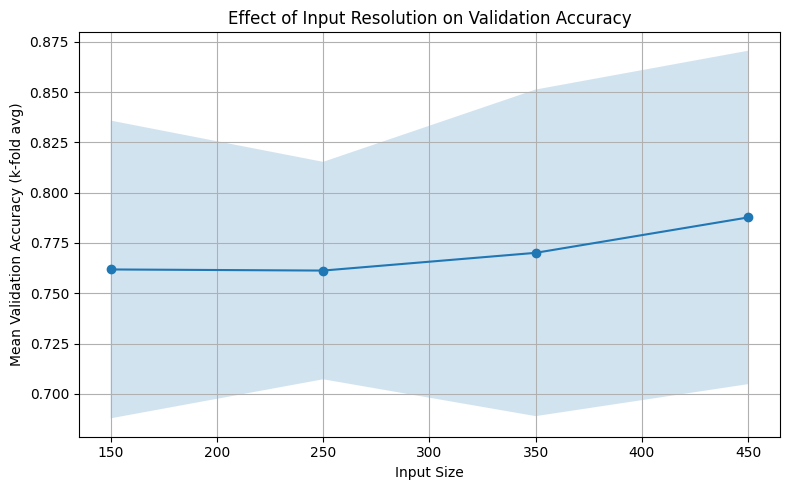

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by input size and compute mean fold accuracy
# (best_val_acc is already mean-over-folds in your setup)
df_size = (
    df.groupby("input_size", as_index=False)
      .agg(
          mean_acc=("best_val_acc", "mean"),
          std_acc=("best_val_acc", "std"),
          n_runs=("best_val_acc", "count"),
      )
      .sort_values("input_size")
)

display(df_size)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_size["input_size"], df_size["mean_acc"], marker="o")
plt.fill_between(
    df_size["input_size"],
    df_size["mean_acc"] - df_size["std_acc"],
    df_size["mean_acc"] + df_size["std_acc"],
    alpha=0.2
)

plt.xlabel("Input Size")
plt.ylabel("Mean Validation Accuracy (k-fold avg)")
plt.title("Effect of Input Resolution on Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
